<a href="https://colab.research.google.com/github/donrockvic/pytorch/blob/master/pytorch_ANN_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('NYCTaxiFares.csv')

In [0]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [0]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [0]:
 def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [0]:
df['dist_km'] = haversine_distance(df,'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude')

In [0]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km'],
      dtype='object')

In [0]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764


In [0]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [0]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [0]:
df['Hour'] = df['EDTdate'].dt.hour

In [0]:
df['AMorPM'] = np.where(df['Hour'] < 12, 'am','pm')

In [0]:
df['weekday'] = df['EDTdate'].dt.strftime('%a')  #dt.dayofweek

In [0]:
cat_cols = ['Hour','AMorPM','weekday']
cont_cols = [ 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count','dist_km']

In [0]:
y_col = df['fare_amount']

In [0]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [0]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
weekday                         category
dtype: object

In [0]:
df['weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [0]:
df['weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [0]:
df['weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [0]:
df['weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [0]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['weekday'].cat.codes.values

In [0]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [0]:
cats = np.stack([hr,ampm,wkdy], axis = 1)

In [0]:
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [0]:
#cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [0]:
cats = torch.tensor(cats, dtype=torch.int64)
cats

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [0]:
conts = np.stack([df[col].values for col in cont_cols], axis =1 )

In [0]:
conts = torch.tensor(conts, dtype =  torch.float)

In [0]:
y = torch.tensor(y_col.values, dtype=torch.float).reshape(-1,1)

In [0]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [0]:
cats.shape

torch.Size([120000, 3])

In [0]:
conts.shape

torch.Size([120000, 6])

In [0]:
y.shape

torch.Size([120000, 1])

In [0]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [0]:
cat_szs

[24, 2, 7]

In [0]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [0]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [0]:
catz = cats[:4]

In [0]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])

In [0]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [0]:
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [0]:
embeddingz

[tensor([[-2.1319, -0.6447,  0.8341, -0.6201, -0.5235,  0.1554,  0.2930, -0.4366,
           2.2260,  0.1512, -0.3793, -0.2725],
         [-0.3371,  0.7107,  2.5442,  1.1296, -0.4475,  0.0518,  0.4763, -0.4248,
           1.1406,  0.3541, -1.1422, -0.5761],
         [ 0.6106,  0.6709, -1.3025,  1.5371, -0.5076, -1.4752, -0.6697,  0.0845,
           0.5203,  1.2858, -0.0416, -0.8415],
         [ 0.5360, -0.4213, -0.1946,  1.1615, -0.1046,  1.0667, -0.4492, -0.8768,
          -2.0357, -0.6318, -1.9019, -1.6997]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.9416],
         [-1.9416],
         [-1.9416],
         [-0.6557]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.5778, -1.2445,  0.0413, -0.3707],
         [-1.0863, -1.6925, -1.3486, -0.0914],
         [-1.0863, -1.6925, -1.3486, -0.0914],
         [ 0.4143, -1.2639,  0.2615, -0.5434]], grad_fn=<EmbeddingBackward>)]

In [0]:
z = torch.cat(embeddingz,1)

In [0]:
z

tensor([[-2.1319, -0.6447,  0.8341, -0.6201, -0.5235,  0.1554,  0.2930, -0.4366,
          2.2260,  0.1512, -0.3793, -0.2725, -1.9416,  0.5778, -1.2445,  0.0413,
         -0.3707],
        [-0.3371,  0.7107,  2.5442,  1.1296, -0.4475,  0.0518,  0.4763, -0.4248,
          1.1406,  0.3541, -1.1422, -0.5761, -1.9416, -1.0863, -1.6925, -1.3486,
         -0.0914],
        [ 0.6106,  0.6709, -1.3025,  1.5371, -0.5076, -1.4752, -0.6697,  0.0845,
          0.5203,  1.2858, -0.0416, -0.8415, -1.9416, -1.0863, -1.6925, -1.3486,
         -0.0914],
        [ 0.5360, -0.4213, -0.1946,  1.1615, -0.1046,  1.0667, -0.4492, -0.8768,
         -2.0357, -0.6318, -1.9019, -1.6997, -0.6557,  0.4143, -1.2639,  0.2615,
         -0.5434]], grad_fn=<CatBackward>)

In [0]:
selfembdrope = nn.Dropout(0.4)

In [0]:
z= selfembdrope(z)

In [0]:
z

tensor([[-3.5531, -1.0744,  0.0000, -1.0335, -0.0000,  0.2590,  0.4883, -0.0000,
          0.0000,  0.0000, -0.6321, -0.0000, -3.2361,  0.9630, -0.0000,  0.0689,
         -0.6178],
        [-0.5619,  1.1846,  0.0000,  1.8826, -0.0000,  0.0000,  0.7938, -0.0000,
          1.9011,  0.5902, -0.0000, -0.0000, -3.2361, -1.8106, -2.8209, -2.2476,
         -0.1524],
        [ 0.0000,  1.1182, -0.0000,  0.0000, -0.0000, -0.0000, -1.1162,  0.0000,
          0.8672,  2.1430, -0.0694, -1.4025, -3.2361, -0.0000, -2.8209, -2.2476,
         -0.1524],
        [ 0.8933, -0.0000, -0.0000,  1.9358, -0.1744,  1.7778, -0.7486, -1.4613,
         -0.0000, -1.0530, -0.0000, -0.0000, -1.0929,  0.0000, -2.1065,  0.0000,
         -0.9057]], grad_fn=<MulBackward0>)

In [0]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [0]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100],p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [0]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [0]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.59199619
epoch:  26  loss: 11.05552101
epoch:  51  loss: 10.39526558
epoch:  76  loss: 9.85915184
epoch: 101  loss: 9.19603348
epoch: 126  loss: 8.36261368
epoch: 151  loss: 7.29208565
epoch: 176  loss: 6.09645700
epoch: 201  loss: 4.91176224
epoch: 226  loss: 4.15342760
epoch: 251  loss: 3.85278440
epoch: 276  loss: 3.77879143
epoch: 300  loss: 3.71119571

Duration: 395 seconds


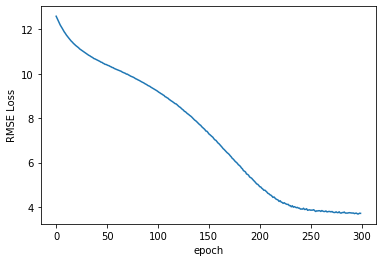

In [0]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [0]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.62655997


In [0]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   6.3261   2.9000   3.4261
 2.  14.4729   5.7000   8.7729
 3.   7.8827   7.7000   0.1827
 4.  12.1304  12.5000   0.3696
 5.   6.9880   4.1000   2.8880
 6.   6.5131   5.3000   1.2131
 7.   4.3076   3.7000   0.6076
 8.  14.6324  14.5000   0.1324
 9.   4.1864   5.7000   1.5136
10.  14.9241  10.1000   4.8241
11.   6.7144   4.5000   2.2144
12.   3.8025   6.1000   2.2975
13.   4.4368   6.9000   2.4632
14.   7.3570  14.1000   6.7430
15.   5.7535   4.5000   1.2535
16.  37.6877  34.1000   3.5877
17.   3.4248  12.5000   9.0752
18.   6.4376   4.1000   2.3376
19.   8.1741   8.5000   0.3259
20.   4.1920   5.3000   1.1080
21.  16.2710  11.3000   4.9710
22.  12.3898  10.5000   1.8898
23.  18.3446  15.3000   3.0446
24.  17.6533  14.9000   2.7533
25.  40.8819  49.5700   8.6881
26.   1.8748   5.3000   3.4252
27.   5.7768   3.7000   2.0768
28.   5.8310   6.5000   0.6690
29.  12.4794  14.1000   1.6206
30.   3.7834   4.9000   1.1166
31.   4.6100   3.7000   0.9100
32.  33.

In [0]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'Data/My Drive/TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [0]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [0]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [0]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [0]:
z = test_data(model2)

What is the pickup latitude?  4.257885
What is the pickup longitude? 7.2545
What is the dropoff latitude?  4.28
What is the dropoff longitude? 8.25
How many passengers? 4
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     01:40:4

The predicted fare amount is $2380.52
